In [22]:
import pandas as pd
import fiona
import geopandas as gpd
import ee
import geemap
from pathlib import Path
import json

In [27]:
# Get paths of MRC files
path_insitu = Path('data/insitu')
paths_xls = list(path_insitu.glob('*.xlsx'))
paths_metadata = list(path_insitu.glob('*.txt'))

# Load in-situ data from .xlsx
df_insitu = pd.DataFrame([])
for path in paths_xls:
    df_temp = pd.read_excel(path, converters={'Station Code':str})
    df_insitu = pd.concat([df_insitu, df_temp])
df_insitu = df_insitu.reset_index()
    
# Load station metadata from .txt
df_metadata = pd.DataFrame([])
for path in paths_metadata:
    with open(path) as f:
        lines = [tuple(line[2:].split(':')) for line in f.readlines()]
        dict_metadata = {line[0]:line[1][1:-1] for line in lines if len(line)==2}
        dict_metadata['station_code'] = dict_metadata['Location identifier'].split('_')[1]
        df_temp = pd.DataFrame.from_dict(dict_metadata ,orient='index').T
        df_metadata = pd.concat([df_metadata, df_temp])
df_metadata = df_metadata.reset_index().drop(columns=['Disclaimer'])

# Load corrected station geometries
path_geojson = list(path_insitu.glob('*points.geojson'))[0]
gdf_geoms = gpd.read_file(path_geojson, transformer={'station_code': str}).set_index('station_code')

C:\ProgramData\Anaconda3\envs\earth-engine\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\ProgramData\Anaconda3\envs\earth-engine\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\ProgramData\Anaconda3\envs\earth-engine\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\ProgramData\Anaconda3\envs\earth-engine\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\ProgramData\Anaconda3\envs\earth-

## Google Earth Engine

### Authenticate and initialize GEE

In [28]:
# # Trigger the authentication flow.
# ee.Authenticate()

# Initialize the library.
ee.Initialize()

### Define GEE functions

In [54]:
def bitwiseExtract(value, fromBit, toBit=None):
    if toBit == None: toBit = fromBit
    maskSize = ee.Number(1).add(toBit).subtract(fromBit)
    mask = ee.Number(1).leftShift(maskSize).subtract(1)
    return value.rightShift(fromBit).bitwiseAnd(mask)

def load_sentinel2_imagery(filter):
    """ Load Sentinel-2 dataset and apply scaling and cloud-masking"""
  
    # Define cloud probability threshold
    MAX_CLOUD_PROBABILITY = 20

    def unmask(img):
        """ Unmask masked pixels (dark water pixels can be masked out) """
        return(img.unmask())

    def apply_cloud_mask(s2Sr):
        """ Apply Sentinel-2 cloud-masking using the COPERNICUS/S2_CLOUD_PROBABILITY dataset """
        def maskClouds(img):
            clouds = ee.Image(img.get('cloud_mask')).select('probability')
            isNotCloud = clouds.lt(MAX_CLOUD_PROBABILITY)
            return img.updateMask(isNotCloud)
        
        # The masks for the 10m bands sometimes do not exclude bad data at
        # scene edges, so we apply masks from the 20m and 60m bands as well.
        def maskEdges(s2_img):
            return s2_img.updateMask(
                s2_img.select('B8A').mask().updateMask(s2_img.select('B9').mask()))

        s2Clouds = ee.ImageCollection("COPERNICUS/S2_CLOUD_PROBABILITY")

        
        # Join the filtered s2cloudless collection to the SR collection by the 'system:index' property.
        s2SrWithCloudMask = ee.ImageCollection(ee.Join.saveFirst('cloud_mask').apply(**{
            'primary': s2Sr,
            'secondary': s2Clouds,
            'condition': ee.Filter.equals(**{
                'leftField': 'system:index',
                'rightField': 'system:index'
            })
        }))

        # Map the maskClouds function to mask out clouds above threshold
        s2CloudMasked = ee.ImageCollection(s2SrWithCloudMask).map(maskClouds)
        return(s2CloudMasked)

    def apply_scale_factors(image):
        """ Applies scaling factors to Sentinel-2 imagery """
        opticalBands = image.select('B.*').multiply(0.0001)
        return image.addBands(opticalBands, None, True)

    def apply_water_mask(image):
        """ Mask water and ice/snow pixels using the S-2 SCL band """
        scl = image.select('SCL')
        water = scl.eq(6);
        return(image.updateMask(water))

    # Load and prepare Sentinel-2 dataset
    s2 = ee.ImageCollection("COPERNICUS/S2_HARMONIZED")\
        .filter(filter)\
        .map(apply_scale_factors)\
        .select('B.*')\
        .map(lambda image: image.set('sensor', 'Sentinel-2'))
        #.map(apply_water_mask)
    
    images = apply_cloud_mask(s2)
    return(images)


def load_landsat_imagery(filter):
    """ Load L7 ETM+, L8 OLI/TIRS, L9 OLI-2/TIRS-2 datasets and apply scaling, cloud-masking and harmonization 
    including ETM+ to OLI spectral spacelinear transformation according to Roy et al. (2016).
    """
    def apply_scale_factors(image):
        """ Apply scaling factors to Landsat imagery. """
        opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2);
        thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0);
        return image.addBands(opticalBands, None, True).addBands(thermalBands, None, True);
        
    def apply_cfmask(image):
        """" Apply masking using CFMASK quality flag """
        qa = image.select('QA_PIXEL')
        dilatedCloud =  bitwiseExtract(qa, 1)
        cirrus =        bitwiseExtract(qa, 2)
        cloud =         bitwiseExtract(qa, 3)
        cloudShadow =   bitwiseExtract(qa, 4)
        snow =          bitwiseExtract(qa, 5)
        clear =         bitwiseExtract(qa, 6)
        water =         bitwiseExtract(qa, 7)
        mask = (cloud.Not()).And(dilatedCloud.Not()).And(cloudShadow.Not()).And(water)
        return(image.updateMask(mask))
    
    #Linear transformation coefficients of ETM+ spectral space to OLI spectral space according to Roy et al. (2016)
    coefficients = {
        'itcps': ee.Image.constant([0.0003, 0.0088, 0.0061, 0.0412, 0.0254, 0.0172]),
        'slopes': ee.Image.constant([0.8474, 0.8483, 0.9047, 0.8462, 0.8937, 0.9071])
    }
    
    # Function to get and rename bands of interest from OLI.
    def renameOli(img):
        return img.select(
            ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'ST_B10', 'QA_PIXEL'],
            ['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2', 'ST', 'QA_PIXEL'])

    # Function to get and rename bands of interest from ETM+.
    def renameEtm(img):
        return img.select(
            ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7', 'ST_B6', 'QA_PIXEL'],
            ['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2', 'ST', 'QA_PIXEL'])
    
    # Convert ETM+ to OLI
    def etmToOli(img):
        return img.select(['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2'])\
        .multiply(coefficients['slopes'])\
        .add(coefficients['itcps'])\
        .addBands(img.select(['ST', 'QA_PIXEL']))
        
    # Define function to prepare OLI images.
    def prepOli(img):
        orig = img
        img = apply_scale_factors(img)
        img = renameOli(img)
        img = apply_cfmask(img)
        return ee.Image(img.copyProperties(orig, orig.propertyNames()))
    
    # Define function to prepare ETM+ images.
    def prepEtm(img):
        orig = img
        img = apply_scale_factors(img)
        img = renameEtm(img)
        img = apply_cfmask(img)
        #img = etmToOli(img)
        return ee.Image(img.copyProperties(orig, orig.propertyNames()))
    
    # Load and prepare ETM+ dataset
    l7 = ee.ImageCollection("LANDSAT/LE07/C02/T1_L2").filter(filter)\
        .map(lambda image: image.set('sensor', 'Landsat-7'))
    etm = l7.map(prepEtm)
  
    # Load and prepare OLI-1/OLI-2 dataset
    l8 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")\
        .filter(filter)\
        .map(lambda image: image.set('sensor', 'Landsat-8'))
    l9 = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2")\
        .filter(filter)\
        .map(lambda image: image.set('sensor', 'Landsat-9'))
    oli = (l8.merge(l9)).map(prepOli)
    
    # Merge ETM+/OLI-1/OLI-2
    images = oli.merge(etm)
    return(images)

## Create collections

In [55]:
# Create FeatureCollection with corrected geometries
import json
json_geoms = json.loads(gdf_geoms.to_json())
keys = [ele['id'] for ele in json_geoms['features']]
values = [(ele['geometry']['coordinates'][0], ele['geometry']['coordinates'][1]) for ele in json_geoms['features']]
dict_coords = dict(zip(keys,values))
list_geoms = []
for key, value in dict_coords.items():
    lat, lon = value[1], value[0]
    ee_geom = ee.Geometry.Point([float(lon), float(lat)])
    list_geoms.append(ee.Feature(ee_geom, {'station_code': key}))
ee_fc_geoms = ee.FeatureCollection(list_geoms)

# Create FeatureCollection of station geometries
list_features = []
for i, row in df_metadata.iterrows():
    station_code = row['station_code']
    #ee_point_station = ee.Geometry.Point([float(row.Longitude), float(row.Latitude)])
    ee_point_station = ee_fc_geoms.filter(ee.Filter.eq('station_code', station_code)).first().geometry().buffer(100)
    ee_f_station = ee.Feature(ee_point_station, row.to_dict())
    list_features.append(ee_f_station)
ee_fc_stations = ee.FeatureCollection(list_features)

# Create FeatureCollection of in-situ measurements
list_features = []
for i, row in df_insitu.iterrows():
    station_code = row['Station Code']
    geom = ee_fc_stations.filter(ee.Filter.eq('station_code', row['Station Code'])).first().geometry()
    ee_f_measurement = ee.Feature(geom, {
        'station_code': row['Station Code'],
        'value': row['Value'],
        'date': ee.Date(row['Timestamp (UTC+07:00)']),
        'system:time_start': ee.Date(row['Timestamp (UTC+07:00)']).millis()
    })
    list_features.append(ee_f_measurement)
ee_fc_insitu = ee.FeatureCollection(list_features)

## Get match-ups

In [56]:
time_buffer = 1
spatial_buffer = 100

def get_matchups(feature):
    geom = feature.geometry()
    date = ee.Date(feature.get('system:time_start'))
    ee_filters = ee.Filter.And(
        ee.Filter.date(date.advance(-time_buffer, 'day'), date.advance(time_buffer, 'day')),
        ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30),
        ee.Filter.bounds(geom)
    )
    ee_ic_matches = load_sentinel2_imagery(ee_filters)
    n_matches = ee_ic_matches.size()
    return(feature.set({'n_matches': n_matches}))

def get_value(feature):
    geom = feature.geometry()
    date = ee.Date(feature.get('system:time_start'))
    ee_filters = ee.Filter.And(
        ee.Filter.date(date.advance(-time_buffer, 'day'), date.advance(time_buffer, 'day')),
        ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30),
        ee.Filter.bounds(geom)
    )
    ee_ic_matches = load_landsat_imagery(ee_filters)
    image = ee_ic_matches.first()
    value = image.reduceRegion(ee.Reducer.mean(), geom.buffer(spatial_buffer), 30),
    im_id = image.id()
    sensor = image.get('sensor')
    return(feature.set({'value_rs': value, 'im_id': im_id, 'sensor': sensor}))

# Compute match-ups
ee_fc_matchups = ee_fc_insitu\
                    .map(get_matchups)\
                    .filter(ee.Filter.gt('n_matches', 0))\
                    .map(get_value)

In [57]:
# Export data
export_task = ee.batch.Export.table.toDrive(
    collection=ee_fc_matchups, 
    folder='Earth Engine (Python)', 
    description='Python - Export TSM matchups S2', 
    fileFormat='CSV')
export_task.start()

In [35]:
# Check status of export
ee.data.getTaskStatus(export_task.id)

[{'state': 'READY',
  'description': 'Python - Export TSM matchups LS fixed',
  'creation_timestamp_ms': 1687431899067,
  'update_timestamp_ms': 1687431899067,
  'start_timestamp_ms': 0,
  'task_type': 'EXPORT_FEATURES',
  'id': '66FSG3FNHZD5K4XDIYZHXDUV',
  'name': 'projects/earthengine-legacy/operations/66FSG3FNHZD5K4XDIYZHXDUV'}]

## Create matchups

In [ ]:
Map = geemap.Map(center=[40,-100], zoom=4)
Map.addLayer(ee_fc_stations, {'color':'red'}, 'Stations')
Map.centerObject(ee_fc_stations, 7)
Map

## Load match-ups

In [59]:
path_matchups = list(Path('G:\Meine Ablage\Earth Engine (Python)').glob('*S2.csv'))[0]
df_matchups = pd.read_csv(path_matchups, dtype={'station_code': str})

IndexError: list index out of range

In [50]:
df_matchups = df_matchups.loc[~df_matchups['value_rs'].str.contains('null')]
df_matchups['red'] = df_matchups['value_rs'].apply(lambda row: row.split('=')[3].split(',')[0]).apply(float)
df_matchups['green'] = df_matchups['value_rs'].apply(lambda row: row.split('=')[2].split(',')[0]).apply(float)
df_matchups['r/g-ratio'] = df_matchups['red']/df_matchups['green']

import math
c1, c2, c3 = 1.904, 1.448, 0.630
df_matchups['estimate'] = df_matchups['r/g-ratio'].apply(lambda x: c1*math.exp(c2*x+c3))

C:\Users\Michael\AppData\Local\Temp\ipykernel_17048\3516557773.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


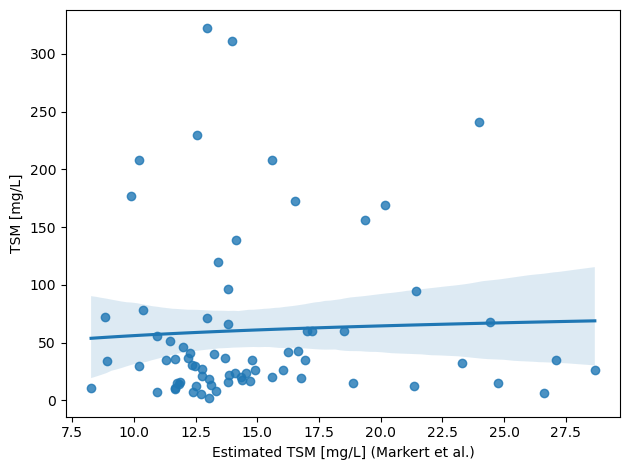

In [51]:
import seaborn as sns
from matplotlib import pyplot as plt


ax = sns.regplot(data=df_matchups,
            x='estimate',
            y='value',
            logx=True,
            order=1)

ax.set(xlabel='Estimated TSM [mg/L] (Markert et al.)', ylabel='TSM [mg/L]')

#plt.yscale('log',base=2) 
#plt.xscale('log',base=2)
#ax.set_aspect('equal', 'box')
plt.tight_layout()
fig.show()

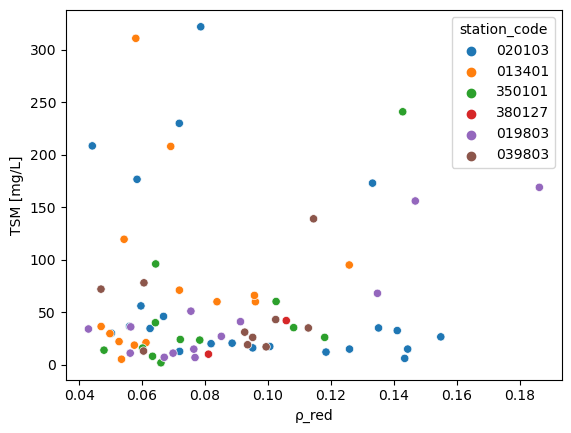

In [53]:
ax = sns.scatterplot(data=df_matchups, y='value', x='red', hue='station_code')
ax.set(xlabel='ρ_red', ylabel='TSM [mg/L]')
plt.show()